In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

In [2]:
## data generation

def gen_data(len_list, trend_list, coeff_list, x0=0.0, noise_level=0.0):
    n = sum(len_list)
    n_r = len(len_list)
    t = np.arange(n)
    x = np.zeros(n)
    
    t_before = 0
    x_before = x0
    for i in range(n_r):   
        t_next = t_before + len_list[i]
        t_range = np.arange(len_list[i])
        if(trend_list[i]=="linear"):
            x_range = x_before + coeff_list[i]*t_range
        elif(trend_list[i]=="exp"):
            x_range = x_before*np.exp(coeff_list[i]*t_range)
        else:
            raise("Unknown trend name!")
        x[t_before:t_next] = x_range
        
        t_before = t_next
        x_before = x_range[-1]
    
    x_noise = np.random.uniform(-1,1, size=n)*noise_level
        
    return t, x+x_noise

In [3]:
a_len = np.array([20,15,20,25,40,10])
a_trend = ["linear", "exp", "exp", "linear", "exp", "linear"]
a_coeff = np.array([2e0, -2e-1, 2e-1, 5e-1, -4e-1, 3e0])

t, x = gen_data(a_len, a_trend, a_coeff, 100, 0.0)
print("x_min = ", np.min(x))

x_min =  6.499125691306981e-05


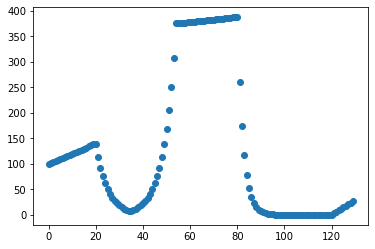

In [4]:
plt.scatter(t, x)

In [6]:
## dp algorithm
def dp_segment(t, x, n_range, fit_range_call, min_len=8, trends = ["linear", "exp"]):
    ## t, x; input data
    ## n_range: number of ranges to get, number of changes is n_range-1
    ## fit_range_call: a callable funciton which does regression for a bunch of increasing models
    ## min_len: minimum length of range. set this since we cannot run regression on 1 data point
    ## trends: the name of increasing models to consider. All the names here should be supported 
    ##   by the user defined fit_range_call()
    
    n = len(t)
    rec = {}
    
    ## init
    #print("DP init...")
    for i in range(min_len-1, n):
        tmp = (np.inf, None, None)
        for trend in trends:
            fit_res = fit_range_call(t[0:i], x[0:i], trend)
            if(fit_res["cost"]<tmp[0]):
                tmp = (fit_res["cost"], fit_res, -1)
        rec[(1, i)] = tmp
    
    ## dp
    
    #number of ranges
    for i in tqdm(range(2, n_range+1), desc="DP", file=sys.stdout):
        #end point
        for j in range(min_len*i-1, n):
            
            tmp = (np.inf, None, None)
            
            #segment point
            for k in range(min_len*(i-1)-1, j-min_len+1):
                for trend in trends:
                    fit_res = fit_range_call(t[k+1:j+1], x[k+1:j+1], trend)
                    cost_combine = rec[(i-1, k)][0] + fit_res["cost"]
                    if(cost_combine < tmp[0]):
                        tmp = (cost_combine, fit_res, k)
                    
                    #print(i, j, k, fit_res, rec[(i-1, k)][0])
                        
            rec[(i, j)] = tmp
    
    #traceback
    p = n-1
    i = n_range
    res = []
    for i in range(n_range, 0, -1):
        tmp = rec[(i, p)]
        
        entry = {}
        entry["trend"] = tmp[1]["trend"]
        entry["coeff"] = tmp[1]["coeff"]
        entry["i_start"] = tmp[2]+1
        entry["i_end"] = p
        res = [entry]+res
        
        p = tmp[2]
        #i-=1
    
    return res, rec[(n_range, n-1)][0]
            

In [7]:
def fit_range(t, x, trend):
    res = {}
    
    if(trend=="linear"):
        tmp = np.polyfit(t, x, 1, full=True)
        res["cost"] = tmp[1][0]
        res["trend"] = trend
        res["coeff"] = tmp[0]
        
    elif(trend=="exp"):
        log_x = np.log(x)
        tmp = np.polyfit(t, log_x, 1)
        x_pred = np.exp(tmp[0]*t+tmp[1])
        
        res["cost"] = np.sum((x_pred - x)**2)
        res["trend"] = trend
        res["coeff"] = tmp
    else:
        raise("Unknown trend name!")
    
    return res

In [9]:
def gen_model_curve(t, x, seg_list):
    n = len(t)
    x1 = np.zeros(n)
    
    for entry in seg_list:
        t_range = t[entry["i_start"]:entry["i_end"]+1]
        if(entry["trend"]=="linear"):
            coeff = entry["coeff"]
            x_range = coeff[0]*t_range + coeff[1]
            x1[entry["i_start"]:entry["i_end"]+1] = x_range
        elif(entry["trend"]=="exp"):
            coeff = entry["coeff"]
            x_range = coeff[0]*t_range + coeff[1]
            x1[entry["i_start"]:entry["i_end"]+1] = np.exp(x_range)
    return x1

In [8]:
seg_res, seg_cost = dp_segment(t, x, 6, fit_range)

DP: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


In [10]:
print("cost = ", seg_cost)
for entry in seg_res:
    print(entry)

cost =  1.1152022301494298e-22
{'trend': 'linear', 'coeff': array([  2., 100.]), 'i_start': 0, 'i_end': 19}
{'trend': 'exp', 'coeff': array([-0.2       ,  8.92725369]), 'i_start': 20, 'i_end': 34}
{'trend': 'exp', 'coeff': array([ 0.2       , -4.87274631]), 'i_start': 35, 'i_end': 54}
{'trend': 'linear', 'coeff': array([  0.5       , 347.62289233]), 'i_start': 55, 'i_end': 79}
{'trend': 'exp', 'coeff': array([-0.4       , 37.95874219]), 'i_start': 80, 'i_end': 119}
{'trend': 'linear', 'coeff': array([   3.        , -359.99993501]), 'i_start': 120, 'i_end': 129}


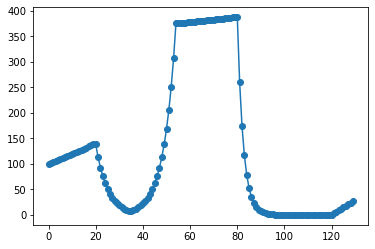

In [13]:
x_fit = gen_model_curve(t, x, seg_res)

plt.scatter(t, x)
plt.plot(t,x)
plt.show()

In [12]:
k_list = []
cost_list = []

for k in range(1,11):
    seg_res, seg_cost = dp_segment(t, x, k, fit_range)
    print(k, seg_cost)
    k_list.append(k)
    cost_list.append(seg_cost)

DP: 0it [00:00, ?it/s]
1 2611651.801319549
DP: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]
2 764059.8686700467
DP: 100%|██████████| 2/2 [00:04<00:00,  2.37s/it]
3 161305.80771480108
DP: 100%|██████████| 3/3 [00:06<00:00,  2.23s/it]
4 82839.46718308778
DP: 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]
5 28065.287571881112
DP: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]
6 1.1152022301494298e-22
DP: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]
7 2.2941378169708355e-24
DP: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]
8 1.3401557025125824e-24
DP: 100%|██████████| 8/8 [00:11<00:00,  1.48s/it]
9 1.3401524217944347e-24
DP: 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]
10 1.3405489923462927e-24


Text(0, 0.5, 'cost')

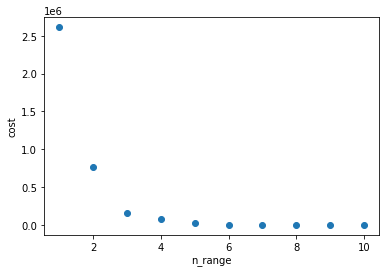

In [13]:
plt.scatter(k_list, cost_list)
plt.xlabel("n_range")
plt.ylabel("cost")

In [14]:
## noise robust
a_len = np.array([20,15,20,25,40,10])
a_trend = ["linear", "exp", "exp", "linear", "exp", "linear"]
a_coeff = np.array([2e0, -2e-1, 2e-1, 5e-1, -4e-1, 3e0])

t, x = gen_data(a_len, a_trend, a_coeff, 100, 10)
x -= (np.min(x)-1)
print("x_min = ", np.min(x))

x_min =  1.0


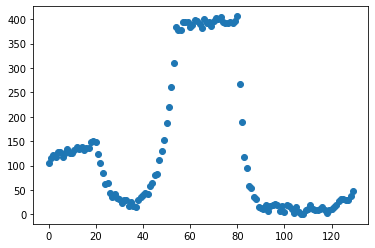

In [15]:
plt.scatter(t, x)

In [16]:
seg_res, seg_cost = dp_segment(t, x, 6, fit_range)

DP: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


In [17]:
print("cost = ", seg_cost)
for entry in seg_res:
    print(entry)

cost =  6574.018909043349
{'trend': 'linear', 'coeff': array([  1.64598607, 114.07591694]), 'i_start': 0, 'i_end': 21}
{'trend': 'exp', 'coeff': array([-0.11419395,  6.93130133]), 'i_start': 22, 'i_end': 35}
{'trend': 'exp', 'coeff': array([ 0.16867888, -3.21917512]), 'i_start': 36, 'i_end': 53}
{'trend': 'linear', 'coeff': array([  0.51186696, 358.3962217 ]), 'i_start': 54, 'i_end': 80}
{'trend': 'exp', 'coeff': array([-0.33221759, 32.45205917]), 'i_start': 81, 'i_end': 90}
{'trend': 'linear', 'coeff': array([  0.43650536, -32.37205533]), 'i_start': 91, 'i_end': 129}


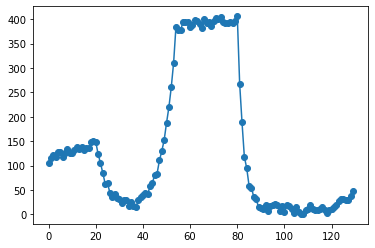

In [18]:
x_fit = gen_model_curve(t, x, seg_res)

plt.scatter(t, x)
plt.plot(t,x)
plt.show()